# Chapter 7. 다양한 모델을 결합한 앙상블 학습

## 7.1 앙상블 학습

여러 분류기를 하나의 메타 분류기로 연결하여 개별 분류기보다 더 좋은 일반화 성능을 달성
개별 분류기에 대한 오류율보다 앙상블의 예측이 틀릴 확률이 훨씬 낮다.

In [1]:
# 이항 분포의 확률 질량 함수 구현하여
# 앙상블 기법의 오류 확률 반환하기
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    prob = [comb(n_classifier, k) *
            error**k *
            (1-error)**(n_classifier - k)
            for k in range(k_start, n_classifier + 1)]
    return sum(prob)

In [2]:
ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

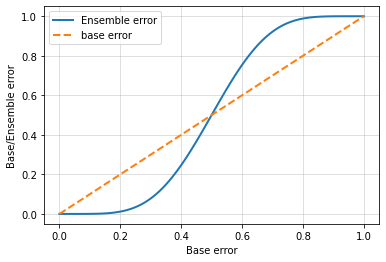

In [3]:
# 앙상블과 개별 분류기 에러 사이의 관계 시각화
import numpy as np
import matplotlib.pyplot as plt

error_range = np.arange(0.0, 1.01, 0.01)
ens_error = [ensemble_error(n_classifier=11, error=error)
             for error in error_range]
plt.plot(error_range, ens_error,
         label='Ensemble error',
         linewidth=2)
plt.plot(error_range, error_range,
         linestyle='--', label='base error',
         linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

# when base error < 0.5, error of ensemble always better than each separator.

## 7.2 다수결 투표를 사용한 분류 앙상블

### 7.2.1 간단한 다수결 투표 분류기 구현

여러가지 분류 모델의 신뢰도에 가중치를 부여하여 연결  
특정 데이터셋에서 개별 분류기의 약점을 보완하는 강력한 메타 분류기를 구축  


In [4]:
# 다수결 투표 구현하기
import numpy as np
np.argmax(np.bincount([0, 0, 1],
                      weights=[0.2, 0.2, 0.6]))

1

In [5]:
# 클래스 확률 기반으로 가중치가 적용된 다수결 투표 구현하기
ex = np.array([[0.9, 0.1],
              [0.8, 0.2],
              [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [6]:
np.argmax(p)

0

### 7.2.2 다수결 투표 방식을 사용하여 예측 만들기

In [7]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50: , [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [8]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     test_size=0.5,
                     random_state=1,
                     stratify=y)

In [9]:
# 로지스틱 회귀, 결정 트리, k-최근접 이웃 분류기 훈련
# -> 10겹 교차검증
# -> AUROC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2',
                          C=0.001,
                          random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                 ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])
clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10겹 교차 검증:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))


10겹 교차 검증:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [10]:
from MajorityVoteClassifier import *
mv_clf = MajorityVoteClassifier(
    classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


In [11]:
# sklearn의 VotingClassifier로 성능 차이 보기
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(estimators=[
    ('lr', pipe1), ('dt', clf2), ('knn', pipe3)], voting='soft')

scores = cross_validate(estimator=vc, X=X_train, y=y_train,
                        cv=10, scoring='roc_auc')
print("ROC AUC: : %0.2f (+/- %0.2f) [%s]"
      % (scores['test_score'].mean(),
         scores['test_score'].std(), 'VotingClassifier'))

ROC AUC: : 0.98 (+/- 0.05) [VotingClassifier]


In [12]:
vc.set_params(verbose=True)

vc = vc.fit(X_train, y_train)

[Voting] ....................... (1 of 3) Processing lr, total=   0.0s
[Voting] ....................... (2 of 3) Processing dt, total=   0.0s
[Voting] ...................... (3 of 3) Processing knn, total=   0.0s


In [13]:
vc.predict_proba(X_test[:10])

array([[0.80858947, 0.19141053],
       [0.80798659, 0.19201341],
       [0.80742142, 0.19257858],
       [0.81176637, 0.18823363],
       [0.81195778, 0.18804222],
       [0.17701319, 0.82298681],
       [0.17670572, 0.82329428],
       [0.17845724, 0.82154276],
       [0.1796252 , 0.8203748 ],
       [0.81076201, 0.18923799]])

### 7.2.3 앙상블 분류기의 평가와 튜닝

- 테스트 데이터셋에 대한 ROC 그리기

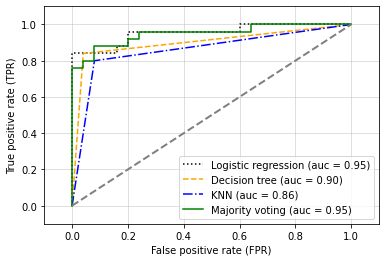

In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', 'orange', 'blue', 'green']
linestyle = [':', '--', '-.', '-']
for clf, label, clr, ls \
    in zip(all_clf, clf_labels, colors, linestyle):
        # 양성 클래스 레이블이 1이라고 가정
        y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
        roc_auc = auc(x=fpr, y=tpr)
        plt.plot(fpr, tpr,
                 color=clr,
                 linestyle=ls,
                 label='%s (auc = %0.2f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

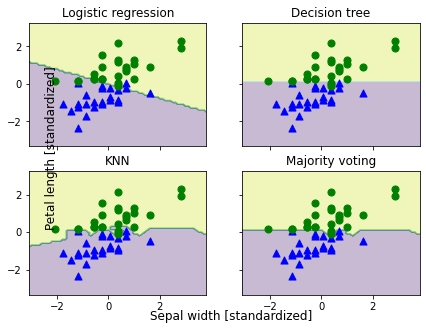

In [15]:
# 결정 경계를 그려 보기
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=2, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(7, 5))
for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                  X_train_std[y_train==0, 1],
                                  c='blue',
                                  marker='^',
                                  s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                  X_train_std[y_train==1, 1],
                                  c='green',
                                  marker='o',
                                  s=50)
    axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5, -4.5,
         s='Sepal width [standardized]',
         ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5,
         s='Petal length [standardized]',
         ha='center', va='center',
         fontsize=12, rotation=90)
plt.show()

In [16]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

In [17]:
from sklearn.model_selection import GridSearchCV
params = {'decisiontreeclassifier__max_depth':[1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               random_state=1)]]),
                                                           DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=1,
                                                                                  random_state=0),
                                                           Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                           

In [19]:
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r], 
             grid.cv_results_['std_test_score'][r] / 2.0, 
             grid.cv_results_['params'][r]))

0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [20]:
print('최적의 매개변수: %s' % grid.best_params_)

최적의 매개변수: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}


In [21]:
print('정확도: %.2f' % grid.best_score_)

정확도: 0.98


In [22]:
# conference
from sklearn.ensemble import StackingClassifier

stack = StackingClassifier(estimators=[
    ('lr', pipe1), ('dt', clf2), ('knn', pipe3)],
                           final_estimator=LogisticRegression())
params = {'dt__max_depth':[1, 2],
          'lr__clf__C':[0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=stack,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=StackingClassifier(estimators=[('lr',
                                                       Pipeline(steps=[('sc',
                                                                        StandardScaler()),
                                                                       ['clf',
                                                                        LogisticRegression(C=0.001,
                                                                                           random_state=1)]])),
                                                      ('dt',
                                                       DecisionTreeClassifier(criterion='entropy',
                                                                              max_depth=1,
                                                                              random_state=0)),
                                                      ('knn',
                                                  

In [23]:
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r],
             grid.cv_results_['std_test_score'][r] / 2.0,
             grid.cv_results_['params'][r]))


0.950 +/- 0.07 {'dt__max_depth': 1, 'lr__clf__C': 0.001}
0.983 +/- 0.02 {'dt__max_depth': 1, 'lr__clf__C': 0.1}
0.967 +/- 0.05 {'dt__max_depth': 1, 'lr__clf__C': 100.0}
0.950 +/- 0.07 {'dt__max_depth': 2, 'lr__clf__C': 0.001}
0.983 +/- 0.02 {'dt__max_depth': 2, 'lr__clf__C': 0.1}
0.967 +/- 0.05 {'dt__max_depth': 2, 'lr__clf__C': 100.0}


In [24]:
print('최적의 매개변수: %s' % grid.best_params_)
print('정확도: %.2f' % grid.best_score_)

최적의 매개변수: {'dt__max_depth': 1, 'lr__clf__C': 0.1}
정확도: 0.98


## 7.3 배깅: 부트스트랩 샘플링을 통한 분류 앙상블